# VGG-16

In [ ]:
!pip install wandb
!wandb login

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 144 kB 42.4 MB/s 
     |████████████████████████████████| 181 kB 44.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=337da1ca6a8b8cdbf05a25bc99b542239afde262cc9c85720cc8c00dd6297013
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb
import tensorflow as tf

wandb.init(project="vgg16-parking-lots", entity="jowellhong")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Train and validate the VGG-16 model on PKLot dataset. The model is trained using transfer learning technique in tensorflow.keras library

In [2]:
# Set tensorflow backend to use only required GPU memory
import tensorflow as tf

#def get_session_growth():
#    config = tf.ConfigProto()
#    config.gpu_options.allow_growth=True
#    sess = tf.Session(config=config)
#    return sess

#sess = get_session_growth()

In [ ]:
#from tensorflow.keras.layers import Flatten, Dense, Dropout
#from tensorflow.keras.models import Model, Sequential
#from tensorflow.keras.optimizers import SGD

In [ ]:
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
HEIGHT = 49
WIDTH = 37

# Instantiate the base model to extract features
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [5]:
TRAIN_DIR = "/content/drive/MyDrive/parking_model/cnn_dataset_22/train/"
BATCH_SIZE = 32

train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True,
      #validation_split=0.9, # we will use only 10% for testing purposes
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                   class_mode='binary', subset='training')

Found 19470 images belonging to 2 classes.


In [ ]:
VALID_DIR = "/content/drive/MyDrive/parking_model/cnn_dataset_22//valid/"
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    #rescale=1./255,
    validation_split=0.9,
)

validation_generator = valid_datagen.flow_from_directory(
        VALID_DIR,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary', subset='training', shuffle=False)

Found 1012 images belonging to 2 classes.


In [ ]:
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 37, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 49, 37, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 49, 37, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 18, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 18, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 18, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 9, 128)        0     

In [ ]:
# Freeze the base model not to train
for layer in base_model.layers:
        layer.trainable = False

In [ ]:
# Define the top/final layers to do classifiction
x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
pred = tf.keras.layers.Dense(1, activation='sigmoid')(x)

tf_model = tf.keras.Model(inputs=base_model.input, outputs=pred)

In [ ]:
print(tf_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 37, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 49, 37, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 49, 37, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 18, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 18, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 18, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 9, 128)        0     

In [ ]:
# Choose the optimizers that works well with the dataset
tf_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# tf_model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# Set the number of train and validation examples, epochs and bact size

# # To train on full dataset, please uncomment this and comment sample dataset 
# nb_train_samples = 81406
# nb_validation_samples = 42384
# batch_size =  BATCH_SIZE

# To train on sample dataset
#nb_train_samples = 100
#nb_validation_samples = 100
#batch_size =  8
epochs = 10

In [ ]:
callback_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001, restore_best_weights=True, mode='min')

In [ ]:
# Fine-tune the model
#tf_hist = tf_model.fit_generator(
#        train_generator,
#        steps_per_epoch=nb_train_samples // batch_size,
#        epochs=epochs,
#        validation_data=validation_generator,
#        validation_steps=nb_validation_samples // batch_size)

In [ ]:
from wandb.keras import WandbCallback
tf_hist = tf_model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[WandbCallback()])

NameError: ignored

In [ ]:
plt.figure(1, figsize = (15,8)) 
plt.subplot(221)  
plt.plot(tf_hist.history['accuracy'])  
plt.plot(tf_hist.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.subplot(222)  
plt.plot(tf_hist.history['loss'])  
plt.plot(tf_hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.show()

In [ ]:
tf_model.save('/content/drive/MyDrive/parking_model/models')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/parking_model/models/assets


## Model prediction on validation dataset

In [ ]:
from glob import glob
import numpy as np
#from utils import load_image
import cv2

In [ ]:
occupied_dir = "/content/drive/MyDrive/parking_model/cnn_dataset_22/valid/Occupied/*.jpg"
empty_dir = "/content/drive/MyDrive/parking_model/cnn_dataset_22/valid/Empty/*.jpg"

valid_images = glob(occupied_dir) + glob(empty_dir)

In [ ]:
valid_sample_size = 1000 # To run  on complete valid dataset. Please set this to 50000 (value greater than number of valid images
valid_images = list(valid_images)
np.random.shuffle(valid_images)
valid_images = valid_images[:valid_sample_size] 

In [ ]:
ground_truth = []
prediction = []
for img in valid_images:
    label = img.split("/")[-2]
    if label == "Occupied":
        ground_truth.append(1)
    else:
        ground_truth.append(0)
    #image = load_image(img)
    image = cv2.imread(img)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    image_x = np.expand_dims(image, axis=0)
    image_x = tf.keras.applications.vgg16.preprocess_input(image_x)
    pred = tf_model.predict(image_x)
    pred = np.squeeze(pred)
    if pred > 0.98:
        prediction.append(1)
    else:
        prediction.append(0)
    

### Validate the model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# Show the classification metrics
print(classification_report(ground_truth, prediction, target_names=['Empty', 'Occupied']))

              precision    recall  f1-score   support

       Empty       0.93      0.99      0.96       567
    Occupied       0.98      0.91      0.94       433

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



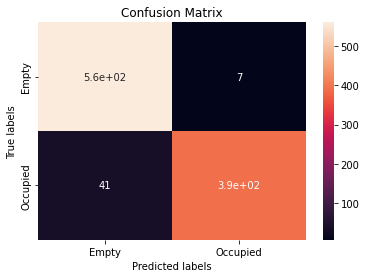

In [ ]:
# confusion matrix
cm = confusion_matrix(ground_truth, prediction)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Empty', 'Occupied']); 
ax.yaxis.set_ticklabels(['Empty', 'Occupied']);

In [ ]:
print("Confusion matrix")
print(cm)

Confusion matrix
[[560   7]
 [ 41 392]]
